**RBF SVM - Marco Patiño and Armando Rodríguez**

In [ ]:
!pip uninstall --yes scikit-learn --quiet 
!pip install scikit-learn --quiet

In [ ]:
!pip install --upgrade --quiet scikit-learn
!pip install --upgrade --quiet lime
!pip install --upgrade --quiet scikit-optimize

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import preprocessing      # Preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from numpy.random import choice
import lime
import lime.lime_tabular
from sklearn.inspection import permutation_importance

In [ ]:
random_state = 10000

Read and split csv

In [ ]:
df = pd.read_csv('botNoBot2018_preprocessed.csv',lineterminator='\n')

Y = df["category"]
X = df.drop(columns="category", axis=1);

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, train_size=0.8, shuffle=True, stratify=Y, random_state=random_state);

Standardize the data

In [ ]:
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

Default model

In [ ]:
knc = SVC(random_state=random_state)
knc.fit(Xtrain,Ytrain);
pred = knc.predict(Xtest);
print(sklearn.metrics.confusion_matrix(Ytest,pred));
print(sklearn.metrics.accuracy_score(Ytest,pred));
cvacc = cross_val_score(SVC(random_state=random_state), X=Xtrain,  y=Ytrain, cv=10, scoring='accuracy',n_jobs=-1)
print('Acc. 10-fold cross on train data= ', cvacc.mean())
print('Std. 10-fold cross on train data= ', cvacc.std())

[[612 462]
 [160 965]]
0.717144156434743
Acc. 10-fold cross on train data=  0.7150839021615473
Std. 10-fold cross on train data=  0.015223939662154337


Grid search for tunning (done many times with different ranges)

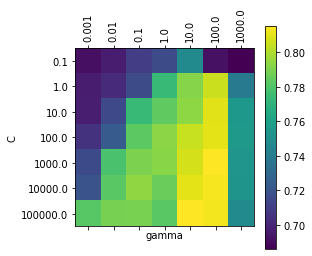


Best combination of parameters found:  {'C': 1000.0, 'gamma': 100.0}

Acc. 2-fold cross on train data=  0.803343949044586


In [ ]:
# Values we will test for each parameter. When observin results, consider the limits of the 
# values tested and increase them if necessary 
gammas = np.logspace(-3, 3, num=7, base=10.0)
Cs = np.logspace(-1, 5, num=7, base=10.0)

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(random_state=random_state), param_grid, cv=5, n_jobs=-1)
grid_search.fit(Xtrain,Ytrain)
parval=grid_search.best_params_

# We'll show in a grid, the accuracy for each combination of parameters tester
scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.matshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'],rotation='vertical')
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.savefig('gammaC.png',bbox_inches='tight')
plt.show()
parval=grid_search.best_params_
print("\nBest combination of parameters found: ",parval)

cvacc = cross_val_score(SVC(C=parval['C'], gamma=parval['gamma'],random_state=random_state) , X=Xtrain,  y=Ytrain, cv=2, scoring='accuracy', n_jobs=-1)
print('\nAcc. 2-fold cross on train data= ', cvacc.mean())


Best model found

In [ ]:
knc = SVC(C=100000, gamma=100, random_state=random_state)
knc.fit(Xtrain,Ytrain);
pred = knc.predict(Xtest);
print(knc.score(Xtest, Ytest))
cvacc = cross_val_score(SVC(C=100000, gamma=100,random_state=random_state) , X=Xtrain,  y=Ytrain, cv=10, scoring='accuracy', n_jobs=-1)
print('\nAcc. 10-fold cross on train data= ', cvacc.mean())
print(sklearn.metrics.confusion_matrix(Ytest,pred));
print(sklearn.metrics.accuracy_score(Ytest,pred));

Classification report

In [ ]:
print(sklearn.metrics.classification_report(Ytest,pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1074
           1       0.87      0.73      0.79      1125

    accuracy                           0.81      2199
   macro avg       0.81      0.81      0.81      2199
weighted avg       0.82      0.81      0.80      2199



Model with probability for interpretability

In [ ]:
knc = SVC(C=100000, gamma=100, probability=True, random_state=random_state)
knc.fit(Xtrain,Ytrain);

ROC curve

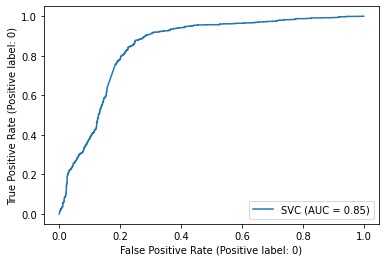

In [ ]:
RocCurveDisplay.from_estimator(knc, Xtest,Ytest, pos_label=0)

Feature importance

In [ ]:
c = choice(Xtest.shape[0], size=2000, replace=False)
pi = permutation_importance(knc,Xtest[c], Ytest.to_numpy()[c], n_jobs=-1, random_state=0)

In [ ]:
var_imp = pd.DataFrame({'importance': pi.importances_mean},
                       index=X.columns)

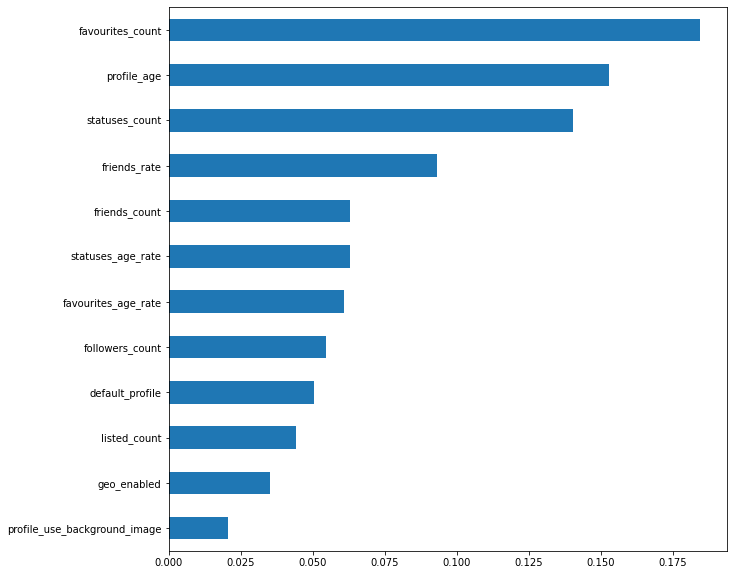

In [ ]:
var_imp.sort_values(by='importance').plot.barh(figsize=(10,10),
                                               legend=False);

LIME (didn't used in the final report)

In [ ]:
i = 0
explainer = lime.lime_tabular.LimeTabularExplainer(Xtrain, feature_names=list(df.columns[:-1]),class_names=['NoDef', 'Def'], verbose=True, mode='classification')
exp = explainer.explain_instance(Xtest[i], knc.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

Intercept 0.44471347441166875
Prediction_local [0.44579563]
Right: 0.579223451187664
